In [1]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

import torch.cuda

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path


from torchvision import datasets, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as func

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
train_on_gpu = torch.cuda.is_available()
DEVICE = torch.device("cpu")

if not train_on_gpu:
    print('CUDA не доступна. Обучение проходит на CPU')
else:
    DEVICE = torch.device("cuda")
    print('CUDA доступна. Обучение проходит на GPU')

CUDA доступна. Обучение проходит на GPU


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!mkdir ~/.kaggle

In [7]:
!ls -l /content/gdrive/MyDrive/kaggle.json

-rw------- 1 root root 66 Sep 29  2023 /content/gdrive/MyDrive/kaggle.json


In [8]:
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c journey-springfield

 98% 513M/521M [00:10<00:00, 81.1MB/s]
100% 521M/521M [00:10<00:00, 51.4MB/s]


In [10]:
!unzip -q journey-springfield

In [11]:
from pathlib import Path
train_path  = Path('/content/train/simpsons_dataset')
test_path  = Path('/content/testset/testset')


In [12]:
train_val_files = sorted(list(train_path.rglob('*.jpg')))
train_val_labels = [i.parent.name for i in train_val_files]

In [13]:
test_val_files = sorted(list(test_path.rglob('*.jpg')))
test_val_labels = [i.parent.name for i in test_val_files]

In [14]:
augmentions = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(RESCALE_SIZE),
        transforms.RandomCrop(RESCALE_SIZE)
        ]),
    transforms.RandomHorizontalFlip(p=1),
    # transforms.RandomRotation(degrees=(-25, 25)),
])

transform_train = transforms.Compose([
    augmentions,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    # transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model_dataset = datasets.ImageFolder(root=train_path, transform=transform_train)

###Дальше нужно провести взвешивание классов. Но для начала попробуй без этого

In [15]:
from collections import Counter

counter = Counter(model_dataset.targets)

class_weights = {i: 1/c for i, c in counter.items()}
weights = np.zeros(len(model_dataset.targets))
for i, (data, label) in enumerate(tqdm(model_dataset)):
    weight = class_weights[label]
    weights[i] = weight

100%|██████████| 20933/20933 [01:23<00:00, 249.30it/s]


In [16]:
sampler = WeightedRandomSampler(weights, num_samples=max(counter.values())*len(counter), replacement=True)
train_dataloader = DataLoader(model_dataset, batch_size=256, sampler=sampler, num_workers=2)

# c = Counter()

# for _, labels in tqdm(train_dataloader):
#     c += Counter(labels.tolist())

# print(c)

100%|██████████| 369/369 [06:05<00:00,  1.01it/s]

Counter({2: 2382, 41: 2349, 14: 2305, 27: 2304, 15: 2302, 22: 2300, 12: 2298, 29: 2289, 9: 2281, 33: 2278, 39: 2274, 24: 2272, 30: 2270, 19: 2270, 0: 2265, 32: 2262, 25: 2260, 34: 2260, 31: 2260, 37: 2259, 36: 2258, 5: 2256, 18: 2256, 1: 2250, 40: 2232, 10: 2232, 17: 2227, 13: 2217, 4: 2215, 35: 2214, 8: 2214, 28: 2214, 20: 2213, 23: 2203, 7: 2194, 16: 2193, 26: 2192, 21: 2185, 11: 2174, 6: 2171, 3: 2153, 38: 2129})


Model


In [17]:
from torch.nn.modules.activation import ReLU
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.lin1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 2400),
            nn.Dropout(p=0.1),
            nn.ReLU()
        )
        self.lin2 = nn.Sequential(
            nn.Linear(2400, 2400),
            nn.Dropout(p=0.05),
            nn.ReLU(),
        )
        self.out = nn.Linear(2400, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.lin2(x)
        logits = self.out(x)
        return logits

In [18]:
print(len(train_dataloader.dataset))

20933


функция обучения

In [22]:
import time
from tqdm.autonotebook import trange
from tqdm.auto import tqdm

def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=20):
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"
    losses = []
    acc = []

    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        for epoch in range(num_epochs):

            model.train(True)
            running_loss = 0.0
            running_corrects = 0
            processing = 0

            for data in tqdm(dataloader):
                # получаем картинки и метки
                inputs, labels = data
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()
                outputs = model(inputs)
                preds = torch.softmax(outputs, -1).argmax(-1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
                processing += inputs.size(0)

            scheduler.step()

            epoch_loss = running_loss / processing
            epoch_acc = running_corrects / processing
            losses.append(epoch_loss)
            acc.append(epoch_acc)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=losses[-1], t_acc=acc[-1]))

    return model, losses, acc

In [23]:
n_classes = len(np.unique(train_val_labels))
model = SimpleCnn(n_classes)
model = model.to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
model, losses, acc = train_model(model, train_dataloader, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=5)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.0072 train_acc 0.5020


  0%|          | 0/369 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.0021 train_acc 0.8499


  0%|          | 0/369 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b798f6c32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b798f6c32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch 003 train_loss: 0.0012 train_acc 0.9127


  0%|          | 0/369 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b798f6c32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b798f6c32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch 004 train_loss: 0.0008 train_acc 0.9396


  0%|          | 0/369 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b798f6c32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b798f6c32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch 005 train_loss: 0.0006 train_acc 0.9518


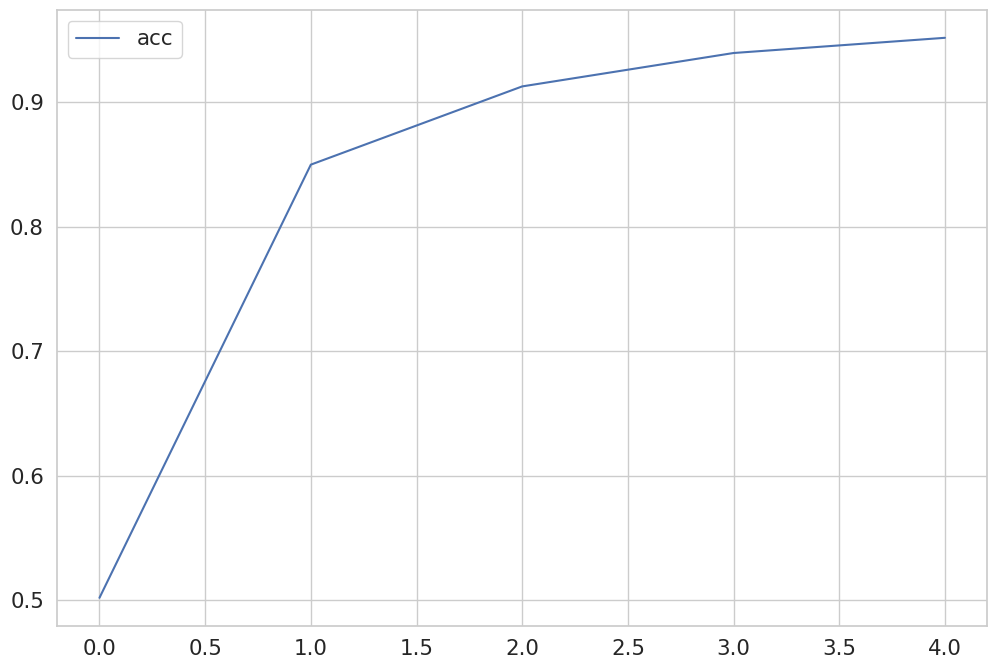

In [25]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(acc, label='acc')
plt.legend()
plt.show()

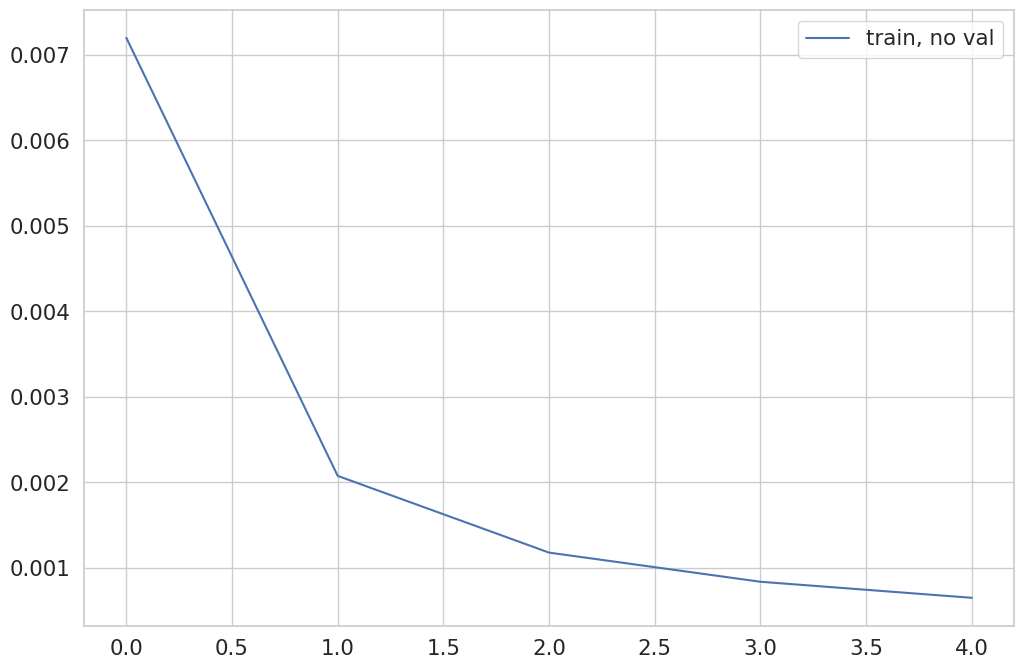

In [26]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(losses, label="train, no val")
plt.legend()
plt.show()

In [ ]:
torch.save(model, Path('/content/gdrive/MyDrive/journey_springfield.pth'))

Дальше только предсказания


In [ ]:
model = torch.load('/content/gdrive/MyDrive/journey_springfield.pth')
model.eval()

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin1): Sequential(
    (0): Linear(in_features=2400, out_fe

In [ ]:
class TestDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
test_dataset = TestDataset(test_val_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
probs = predict(model, test_loader)

In [ ]:
preds = [model_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('/content/gdrive/MyDrive/simple_cnn_baseline_2try.csv', index=False)